<a href="https://colab.research.google.com/github/pSN0W/Transformers/blob/main/NMT_English_To_French.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation using Transformers


In this project I will implement transformer from scratch and then use it for neural machine translation to convert english to french

## Importing Dependencies

In [ ]:
import numpy as np
import matplotlib as plt
import seaborn as sns
import re
import os
import tqdm.notebook as tq
import time
from google.colab import drive

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

## Data Preprocessing


### Loading files

In [ ]:
# mount the drive first
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Give a base dir for your files

BASE_DIR = '/content/drive/MyDrive/NMT_En_to_Fr'

In [ ]:
# writing a function to read from file and return the data in it

def read_data_from_file(file_path):
    with open(file_path) as f:
        data = f.read()
    return data

In [ ]:
# load data from the files in variable

# Data that will be used for translation
europal_en = read_data_from_file(os.path.join(BASE_DIR,'europarl-v7.fr-en.en'))
europal_fr = read_data_from_file(os.path.join(BASE_DIR,'europarl-v7.fr-en.fr'))

# Frefixes that ends with '.' but doesn't necessarily mean they are end of sentence like a.m.
non_breaking_prefixes_en = read_data_from_file(os.path.join(BASE_DIR,'non_breaking.en'))
non_breaking_prefixes_fr = read_data_from_file(os.path.join(BASE_DIR,'non_breaking.fr'))

### Cleaning Data


In [ ]:
# The non_breaking prefixes in the file are stored in the form of one non_breaking prefix per line
# additionaly they don't end with '.' for example it is stored as 'Mr' not 'Mr.'

# convert 'Mr' to ' Mr.'

non_breaking_prefixes_en_list = [' '+prefix+'.' for prefix in non_breaking_prefixes_en.split('\n')]
non_breaking_prefixes_fr_list = [' '+prefix+'.' for prefix in non_breaking_prefixes_fr.split('\n')]

non_breaking_prefixes_en_list[:5]

[' A.', ' B.', ' C.', ' D.', ' E.']

In [ ]:
# Function to clean the data 

# we first replace all the non_breaking '.' with '.###'
# and then at the end replace '.###' with ' '

def clean_corpus(corpus):

    # replace the non ending prefixes ' Mr.' -> ' Mr.###'
    for prefix in non_breaking_prefix_en_list+non_breaking_prefix_fr_list:
        corpus = corpus.replace(prefix,prefix+'###')

    # replace the '.' not followed by space with '.###'
    corpus = re.sub(r"\.(?=[A-Z]||[a-z]||[0-9])",'.###',corpus)

    # replace '.###' with ' '
    corpus = re.sub(".###",' ',corpus)

    # replace more than one spaces with a single one
    corpus = re.sub('  +',' ',corpus)

    # return a list of clean corpus
    return corpus.split('\n')


In [ ]:
# clean the english and french corpus

corpus_en = clean_corpus(europal_en)
corpus_fr = clean_corpus(europal_fr)

### Tokenization

We will be using SubwordTextTokenizer as it helps us in avoiding the problem of OOV tokens by breaking them into subwords and then using them for encoding

In [ ]:
# build your tokenizer
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(corpus_en,target_vocab_size=2**13)
tokenizer_fr = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(corpus_fr,target_vocab_size=2**13)

# save the tokenizer to a file
tokenizer_en.save_to_file(os.path.join(BASE_DIR,'tokenier_en'))
tokenizer_fr.save_to_file(os.path.join(BASE_DIR,'tokenier_fr'))

In [ ]:
# load the tokenizer to tokenize the data
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.load_from_file(os.path.join(BASE_DIR,'tokenier_en'))
tokenizer_fr = tfds.deprecated.text.SubwordTextEncoder.load_from_file(os.path.join(BASE_DIR,'tokenier_fr'))

# set vocab size
VOCAB_SIZE_EN = tokenizer_en.vocab_size+2 # 2 for <sos> and <eos> token
VOCAB_SIZE_FR = tokenizer_fr.vocab_size+2


In [ ]:
# encoding the data
# using VOCAB_SIZE-2 for <sos> and VOCAB_SIZE-1 for <eos>
inputs = [[VOCAB_SIE_EN-2]+tokenizer_en.encode(sentence)+[VOCAB_SIZE_EN-1] for sentence in corpus_en]
outputs = [[VOCAB_SIE_FR-2]+tokenizer_fr.encode(sentence)+[VOCAB_SIZE_FR-1] for sentence in corpus_fr]

In [ ]:
# plotting the cdf of length

def plot_cdf_for_length_of_sequence(sequence):
    length_of_sequences = [len(sentence) for sentence in sequence]
    print(np.percentile(length_of_sequences,[50,60,70,80,85,90,95,100]))
    sns.ecdfplot(data=length_of_sequences)

[  29.   33.   39.   45.   50.   57.   68. 1221.]


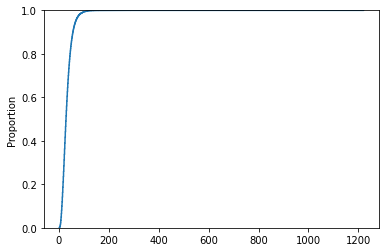

In [ ]:
plot_cdf_for_length_of_sequence(inputs)

[  34.   39.   45.   54.   59.   67.   80. 1420.]


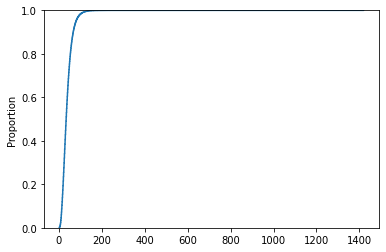

In [ ]:
plot_cdf_for_length_of_sequence(outputs)

### Remove Long Sentances

In [ ]:
# From the graph and percetile it looke like max_length=40 will be good but due to computational constraint
# we will use max length of sequence as 20

MAX_LENGTH = 20

In [ ]:
# now we will remove sequences greater than MAX_LENGTH

# get the index to remove
idx_to_remove = [idx for idx,sentance in enumerate(inputs) if len(sentance)>MAX_LENGTH]

# remove those indexes
for idx in reversed(idx_to_remove):
    del inputs[idx]
    del outputs[idx]

# get the index to remove
idx_to_remove = [idx for idx,sentance in enumerate(outputs) if len(sentance)>MAX_LENGTH]

# remove those indexes
for idx in reversed(idx_to_remove):
    del inputs[idx]
    del outputs[idx]

### Pad Sequences

In [ ]:
# Now we will pad the input and output for them to be of the same size

inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                      value=0,
                                                      padding="post",
                                                      maxlen=MAX_LENGTH
                                                    )

outputs = tf.keras.preprocessing.sequence.pad_sequences(outputs,
                                                      value=0,
                                                      padding="post",
                                                      maxlen=MAX_LENGTH
                                                    )

### Converting to tensorflow dataset

In [ ]:
# Defining batchsize and buffer size 

BATCH_SIZE = 64
BUFFER_SIZE = 20000

In [ ]:
# Convert to tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((inputs,outputs))


In [ ]:
# save the dataset
tf.data.experimental.save(dataset,os.path.join(BASE_DIR,'processed_data'))

In [ ]:
# load the saved data
dataset = tf.data.experimental.load(os.path.join(BASE_DIR,'processed_data'))

# cache it to improve performance
dataset = dataset.cache()

# shuffle it to increase robustness
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# prefetch it to improve performance
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Model 

### Positional Encoding

Since the transformer are unable to get information on the position of the word in the sequence we add this information ourself by creating Positional Encoding using the formula<br>
<h3 align="center"> $$ PE_{(pos,2i)} = sin(\frac{pos}{10000^{2i/d_{model}}})$$ </h3>
<h3 align="center"> $$ PE_{(pos,2i+1)} = cos(\frac{pos}{10000^{2i/d_{model}}})$$ </h3><br>
<h4 align="justify"> pos = Position of the word in sequence <br>
d<sub>model</sub> = Embedding dimension of the word vector<br>
i = We will create the position embedding for a word of length d<sub>model</sub>.  Now here i is the index in of the Position Embedding that means if d<sub>model</sub> = 4 i = [0,1,2,3]
<h4>


In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self):
        super(PositionalEmbedding,self).__init__()

    def get_angles(self,pos,i,d_model):
        """
        Arguments:
            pos     = An array corresponding to all the word indices [0,d_model)            shape = (seq_len,1)
            i       = indexes for Positional Embedding Vector for a position in dequence    shape = (1,d_model)
            d_model = dimensions of the word embedding
        Returns:
            All the angles corresponding to the positional encoding                         shape = (seq_len,d_model)
        """

        # 10000^(2*i/d_model)
        # Here we will use the formula 10000^((2*(i//2))/d_model) instead as we are calculating PE for (pos,i)
        # we add minus sign case we want the power to be -1 to equate 1/{value of expression}
        denominator_of_angle = np.power(10000,(-2*(i//2))/np.float32(d_model))

        # once we have converted each of the position in the PE vector to required form
        # next what we need to do is to multipy pos with the denominator
        # for this we will take advantage of broadcasting in nummpy
        angles = pos * denominator_of_angle

        return angles

    def call(self,embedded_inputs):
        """
        Arguments:
            embedded_inputs = This layer gets input from the embedding layer    shape = (batch_size,seq_len,d_model)
        Returns:
            The new embedding after adding positional embedding to word embedding 
        """

        seq_length = embedded_inputs.shape.as_list()[-2]
        d_model    = embedded_inputs.shape.as_list()[-1]

        # getting position and i vector
        pos = np.arange(seq_length).reshape(seq_length,1)
        i   = np.arange(d_model).reshape(1,d_model)

        # getting the angle from those vectors
        angles = self.get_angles(pos=pos,i=i,d_model=d_model)

        # now we need to apply sin on all the even index of sequence and cos on the odd
        # we take all the sequence and the to apply sin start from begining and take a jump of 2
        # for cos we start from first index and then take a jump of 2
        angles[:,::2]  = np.sin(angles[:,::2])
        angles[:,1::2] = np.cos(angles[:,1::2])

        # we add new axis to angles to make it able to sum with embedded_inputs '...' means keep everything be
        pos_encoding = angles[np.newaxis,...]

        # we add positional embedding with word embedding to create new embedding
        new_embedding = embedded_inputs+tf.cast(pos_encoding,tf.float32)

        return new_embedding


### Attention Computation

#### Scaled Dot Product Attention

The most basic type of attention is dot product attention. Here we multipy the key vector by query vector first to know the dependence and then softmax is taken to have a probabilistic interpretation of things. Here we also use a scaling factor of ${\sqrt{D_k}}$ which is dimension of the keys to avoid gradient explosion problem <br>
<h3> Simply put
$$ Attention(Q,K,V) = softmax({\frac{QK^T}{ \sqrt{D_k}}})V $$
</h3>

The following image display dot product attention <br>
The input are first passed through linear layers to compute Q,K,V vectot and then attention is calculated

<p align="center"><img src="https://miro.medium.com/max/640/1*kxR_DjBgFw7LTTN-Ut34Pw.gif" ></p>


In [ ]:
def scaled_dot_product_attention(query,key,value,mask):
    """
    Arguments:
        query = The query vector we get after passing through liner layer       shape = (batch_size,num_head,seq_len,dim_head)
        key   = The key   vector we get after passing through liner layer       shape = (batch_size,num_head,seq_len,dim_head)
        value = The value vector we get after passing through liner layer       shape = (batch_size,num_head,seq_len,dim_head)
        mask  = A optional matrix to apply mask before computing softmax        shape = (batch_size,1,seq_len,1)
    Returns:
        Attention(Q,K,V) as defined by the above formula
    """

    # We find our Dk and convert it to float to avoid compications on divison
    keys_dim = tf.cast(tf.shape(key)[-1],tf.float32)

    # Now we find the attention score by doing Q@K.T
    attention_score = tf.matmul(query,key,transpose_b=True)

    # Now we do scaling of the attention score
    scaled_attention_score = attention_score/tf.math.sqrt(keys_dim)

    # we apply mask if mask is available
    if mask is not None:
        scaled_attention_score += (mask*-1e9)

    # we find the attention weight by applying softmax
    attention_weight = tf.nn.softmax(scaled_attention_score,axis=-1)

    # find attention by multiplying it with value
    attention = tf.matmul(attention_weight,value)

    return attention


#### Multiheaded attention


While calculating attention in transformer we break the query key and value vector int multiple subvectors and then pass all these subvectors through different attention calculator (known as heads) and then after attention is done for all the heads we concatenate them to get our final vector.

Simply put <br>
Queries, Keys and Values vector are broken in multiple projections based on their last dimensions and then each of these subvectors are passed through multiple heads for attention calculation and then at the end they are concatenated.

<p align="center"> <img src="https://miro.medium.com/max/640/0*X0c962yMhgRKfMTD.gif"> </p>

At the end we pass it through linear layer. The below image can help us to understand the architecture of multi head attention better
<p align="center"> <img src="https://miro.medium.com/max/700/0*4Qos9ymoz4LW1pmP.png"> </p>


In [ ]:
class MultiHeadedAttention(layers.Layer):
    def __init__(self,num_heads):
        """
            num_proj = number of projection(or heads)
        """
        super(MultiHeadedAttention,self).__init__()
        self.num_heads = num_heads

    def build(self,input_shape):
        # Embeding dimension
        self.d_model = input_shape[-1]

        # make sure that embedding dimension is completely divisible by num_heads
        assert self.d_model%self.num_heads == 0

        # last dimension after breaking
        self.dim_heads  = self.d_model//self.num_heads
        # declare linear layers to pass our input through
        self.linear_k = layers.Dense(units=self.d_model)
        self.linear_q = layers.Dense(units=self.d_model)
        self.linear_v = layers.Dense(units=self.d_model)

        # Final dense layer to pass the vectors after concatenation
        self.linear_fin = layers.Dense(units=self.d_model)

    def split_mat(self,input,batch_size):
        """
        Arguments:
            input      : The matrix we want to split    shape = (batch_size,seq_length,d_model)
        Returns:
            tensor after breaking it into parts         shape = (batch_size,seq_length,num_heads,dim_heads)
        """

        # we will split the tensor by reshaping it in this dimension
        target_shape = (batch_size,-1,self.num_heads,self.dim_heads)

        # split the input
        splitted_input = tf.reshape(input,shape=target_shape)

        # once splitted we will reshape is to the required dimension
        fin_splitted_input = tf.transpose(splitted_input,perm=[0,2,1,3])

        return fin_splitted_input

    def call(self,query,key,value,mask):
        """
        Arguments:
            query = The query vector        shape = (batch_size,seq_len,d_model)
            key   = The key   vector        shape = (batch_size,seq_len,d_model)
            value = The value vector        shape = (batch_size,seq_len,d_model)
            mask  = A optional matrix to apply mask before computing softmax        shape = (batch_size,1,seq_len,1)
        Returns:
            Attention(Q,K,V) as defined by the above formula
        """

        # get batch_size
        batch_size = tf.shape(query)[0]

        # passing through linear layer
        query = self.linear_q(query)
        key   = self.linear_k(key)
        value = self.linear_v(value)

        # splitting the query key and value
        query = self.split_mat(query,batch_size)
        key   = self.split_mat(key,batch_size)
        value = self.split_mat(value,batch_size)

        # apply attention on them
        attention = scaled_dot_product_attention(query=query,key=key,value=value,mask=mask)

        # getting it in the shape (batch_size,seq_len,num_heads,dim_heads) for concatenation
        attentions = tf.transpose(attention,perm=[0,2,1,3])

        # concatenating the attention
        concat_attention = tf.reshape(attentions,shape=[batch_size,-1,self.d_model])

        # pass it through final linear layer
        outputs = self.linear_fin(concat_attention)

        return outputs


### Encoder

#### Encoder Layer

Encoder layer is just a single layer of encoder that can be repeated multiple times to make a deep encoder layer. <br>
It contains the layers in the following manner.
<ul>
    <li>MultiHeaded Attention</li>
    <li>Dropout</li>
    <li>LayerNormalization</li>
    <li>Dense with Relu</li>
    <li>Dense</li>
    <li>Dropout</li>
    <li>LayerNormalization</li>
</ul>

<p align="center"><img src="https://jalammar.github.io/images/t/transformer_resideual_layer_norm_2.png"> </p> 

In [ ]:
class EncoderLayer(layers.Layer):
    def __init__(self,FFN_units,num_heads,dropout):
        super(EncoderLayer,self).__init__()
        self.FFN_units = FFN_units
        self.num_heads = num_heads
        self.dropout   = dropout

    def build(self,input_shape):
        # get embedding dim
        self.d_model = input_shape[-1]

        # attention
        self.multihead_attention = MultiHeadedAttention(self.num_heads)

        # residual connection
        self.dropout_1 = layers.Dropout(rate=self.dropout)
        self.norm_1     = layers.LayerNormalization(epsilon=1e-6)

        # Feed Forward Network
        self.dense_1 = layers.Dense(units=self.FFN_units,activation='relu')
        self.dense_2 = layers.Dense(units=self.d_model)

        # residual connection
        self.dropout_2 = layers.Dropout(rate=self.dropout)
        self.norm_2     = layers.LayerNormalization(epsilon=1e-6)

    def call(self,inputs,mask,training):
        """
        Arguments
            inputs   : Input to the encoder layer                       shape = (batch_size,seq_len,d_model)
            mask     : Mask that needs to be applied                    shape = ()
            training : True or False denoting if it's training or not

        Returns
            Result after passing through the encoderlayer
        """
        attention = self.multihead_attention(inputs,inputs,inputs,mask)
        attention = self.dropout_1(attention,training=training)

        # add and normalise
        attention = self.norm_1(attention+inputs)

        # feed forward network
        outputs = self.dense_1(attention)
        outputs = self.dense_2(outputs)
        outputs = self.dropout_2(outputs,training=training)

        # add and normalise
        outputs = self.norm_2(outputs+attention)

        return outputs

#### Encoder

Encoder is the complete encoder layer of the transformer and it contains layers stacked in the following manner.
<ul>
    <li> Embedding </li>
    <li> POS Encoding </li>
    <li> Dropout </li>
    <li> EncoderLayers </li>
</ul>
<p align="center"><img src="https://www.factored.ai/wp-content/uploads/2021/09/image2-580x1024.png"></p>

In [ ]:
class Encoder(layers.Layer):
    def __init__(self,num_layers,FFN_units,num_heads,dropout,vocab_size,d_model,name='Encoder'):
        super(Encoder,self).__init__(name=name)
        self.num_layers = num_layers
        self.d_model    = d_model

        self.embedding    = layers.Embedding(vocab_size,d_model)
        self.pos_encoding = PositionalEmbedding()
        self.dropout      = layers.Dropout(rate=dropout)

        # Put the multiple encoding layer in a list
        self.enc_layers   = [EncoderLayer(FFN_units,num_heads,dropout) for _ in range(num_layers)]

    def call(self,inputs,mask,training):
        outputs = self.embedding(inputs)

        # multiply it by sqrt(d_model) as suggested in paper
        outputs *= tf.math.sqrt(tf.cast(self.d_model,tf.float32))    

        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs,training=training)

        # pass output through all the encoder layers
        for i in range(self.num_layers):
            outputs = self.enc_layers[i](outputs,mask,training)

        return outputs


### Decoder

#### Decoder Layer

First we create the decoder layer that is the building block for the decoder we will be building. <br>
It contains the following layers stacked in this fashion
<ul>
    <li> MultiHeadAttention with look ahead mask </li>
    <li> Dropout </li>
    <li> LayerNormalization </li>
    <li> MultiHeadAttention </li>
    <li> Dropout </li>
    <li> LayerNormalization </li>
    <li> Dense with ReLU </li>
    <li> Dense</li>
    <li> Dropout </li>
    <li> LayerNormalization </li>
</ul>

<p align="center"><img src="https://i.stack.imgur.com/kOs4Z.png"></p>

In [ ]:
class DecoderLayer(layers.Layer):
    def __init__(self,FFN_units,num_heads,dropout):
        super(DecoderLayer,self).__init__()
        self.FFN_units = FFN_units
        self.num_heads = num_heads
        self.dropout   = dropout

    def build(self,input_shape):
        # getting embd dim
        self.d_model = input_shape[-1]

        # MultiHead Attention with look ahead mask
        self.multi_headed_attention_1 = MultiHeadedAttention(self.num_heads)
        self.dropout_1                = layers.Dropout(rate=self.dropout)
        self.norm_1                   = layers.LayerNormalization(epsilon=1e-6)

        # MultiHead Attention
        self.multi_headed_attention_2 = MultiHeadedAttention(self.num_heads)
        self.dropout_2                = layers.Dropout(rate=self.dropout)
        self.norm_2                   = layers.LayerNormalization(epsilon=1e-6)

        # FeedForward network
        self.dense_1 = layers.Dense(units=self.FFN_units,activation='relu')
        self.dense_2 = layers.Dense(units=self.d_model)

        # residual connection
        self.dropout_3  = layers.Dropout(rate=self.dropout)
        self.norm_3     = layers.LayerNormalization(epsilon=1e-6)

    def call(self,inputs,enc_outputs,mask_1,mask_2,training):
        """
        Arguments:
            inputs : Input to the encoder
            enc_outputs : Output from the decoder
            mask_1 : look ahead mask
            mask_2 : mask for sencond multihead attention
            training : boolean denoting if it is training
        """
        # first attention
        attention = self.multi_headed_attention_1(inputs,inputs,inputs,mask_1)
        attention = self.dropout_1(attention,training=training)

        # add and norm
        attention = self.norm_1(attention+inputs)

        # second attention
        attention_2 = self.multi_headed_attention_2(attention,enc_outputs,enc_outputs,mask_2)
        attention_2 = self.dropout_2(attention_2,training=training)

        # add and norm
        attention_2 = self.norm_2(attention+attention_2)

        # feed forward
        outputs = self.dense_1(attention_2)
        outputs = self.dense_2(outputs)

        # residual connection
        outputs = self.dropout_3(outputs,training=training)

        # add and norm
        outputs = self.norm_3(outputs+attention_2)

        return outputs

#### Decoder

This is the final decoder layer and it consist of the following layers stacked together.
<ul>
    <li> Embedding </li>
    <li> POS Encoding </li>
    <li> Dropout </li>
    <li> EncoderLayers </li>
</ul>
<p align="center"><img src="https://miro.medium.com/max/1042/1*AOQlFGXhx_ojDcEX1stg2g.png"> </p>

In [ ]:
class Decoder(layers.Layer):
    def __init__(self,num_layers,FFN_units,num_heads,dropout,vocab_size,d_model,name='Decoder'):
        super(Decoder,self).__init__(name=name)
        self.num_layers = num_layers
        self.d_model    = d_model

        self.embedding    = layers.Embedding(vocab_size,d_model)
        self.pos_encoding = PositionalEmbedding()
        self.dropout      = layers.Dropout(rate=dropout)

        # Put the multiple encoding layer in a list
        self.dec_layers   = [DecoderLayer(FFN_units,num_heads,dropout) for _ in range(num_layers)]

    def call(self,inputs,enc_outputs,mask_1,mask_2,training):
        outputs = self.embedding(inputs)

        # multiply it by sqrt(d_model) as suggested in paper
        outputs *= tf.math.sqrt(tf.cast(self.d_model,tf.float32))    

        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs,training=training)

        # pass output through all the encoder layers
        for i in range(self.num_layers):
            outputs = self.dec_layers[i](outputs,enc_outputs,mask_1,mask_2,training)

        return outputs

## Transformer

Since we have already built the components of transformer, building the transformer is easy. We just need to pass the final output of decoder through a dense layer to get desired output.
<p align="center"><img src="https://miro.medium.com/max/400/1*tkC_NqylGH4hv2rTLPOf5A.png"></p>

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 vocab_size_enc,
                 vocab_size_dec,
                 d_model,
                 num_layers,
                 FFN_units,
                 num_heads,
                 dropout,
                 name='Transformer'):
        super(Transformer,self).__init__()
        # Encoder
        self.encoder = Encoder(num_layers,FFN_units,num_heads,dropout,vocab_size_enc,d_model)

        # Decoder
        self.decoder = Decoder(num_layers,FFN_units,num_heads,dropout,vocab_size_dec,d_model)

        # Dense Layer
        self.fin_linear = layers.Dense(units=vocab_size_dec)

    def create_padding_mask(self,seq):
        """
        Arguments:
            seq : A sequence of shape (batch_size,seq)
        Returns:
            A mask to mask all the paddings    
        """
        mask = tf.cast(tf.math.equal(seq,0),tf.float32)
        return mask[:,tf.newaxis,tf.newaxis,:]

    def create_look_ahead_mask(self,seq):
        """
        Arguments:
            seq : A sequence of shape (batch_size,seq)
        Returns:
            A mask to mask all the future values    
        """
        seq_len = tf.shape(seq)[1]
        look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len,seq_len)),-1,0)
        return look_ahead_mask

    def call(self,enc_inputs,dec_inputs,training):
        enc_mask = self.create_padding_mask(enc_inputs)
        dec_mask_1 = tf.maximum(self.create_padding_mask(dec_inputs),self.create_look_ahead_mask(dec_inputs))
        dec_mask_2 = self.create_padding_mask(enc_inputs)

        enc_outputs = self.encoder(enc_inputs,enc_mask,training)
        dec_outputs = self.decoder(dec_inputs,enc_outputs,dec_mask_1,dec_mask_2,training)
        outputs = self.fin_linear(dec_outputs)

        return outputs
    

## Training

### Model Preparation

In [ ]:
# Declare constants

tf.keras.backend.clear_session()

# Parameter = value used here # value used in paper

D_MODEL    = 128   # 512
NUM_LAYERS = 4     # 6
NUM_HEADS  = 8     # 8
FFN_UNITS  = 512   # 2048
DROPOUT    = 0.1   # 0.1

In [ ]:
# Define Model
transformer = Transformer(
    vocab_size_enc = VOCAB_SIZE_EN,
    vocab_size_dec = VOCAB_SIZE_FR,
    d_model        = D_MODEL,
    num_layers     = NUM_LAYERS,
    FFN_units      = FFN_UNITS,
    num_heads      = NUM_HEADS,
    dropout        = DROPOUT
)

### Custom loss function

In [ ]:
# The loss we will be using
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss_function(target,pred):
    mask = tf.math.logical_not(tf.math.equal(target,0))
    loss_ = loss_object(target,pred)
    mask = tf.cast(mask,dtype=loss_.dtype)
    loss_*=mask
    return tf.reduce_mean(loss_)

train_loss = tf.keras.metrics.Mean(name="train-loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train-accuracy')

### Custom Learning Rate

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self,d_model,warmup_steps=4000):
        super(CustomSchedule,self).__init__()
        self.d_model = tf.cast(d_model,tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self,step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step*(self.warmup_steps**-1.5)
        return tf.math.rsqrt(self.d_model)*tf.math.minimum(arg1,arg2)


In [ ]:
# Defining Optimier

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate,
    beta_1 = 0.9,
    beta_2 = 0.98,
    epsilon = 1e-9
)

In [ ]:
for (enc_inputs,targets) in dataset:
    dec_inputs = targets[:,:-1]
    dec_outputs = targets[:,1:]
    predictions = transformer(enc_inputs,dec_inputs,True)
    break

In [ ]:
transformer.summary()

Model: "transformer_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Encoder)           multiple                  1841408   
                                                                 
 Decoder (Decoder)           multiple                  2100864   
                                                                 
 dense_130 (Dense)           multiple                  1050705   
                                                                 
Total params: 4,992,977
Trainable params: 4,992,977
Non-trainable params: 0
_________________________________________________________________


In [ ]:
transformer.trainable_variables[1]


<tf.Variable 'transformer_2/Encoder/encoder_layer_8/multi_headed_attention_24/dense_133/kernel:0' shape=(128, 128) dtype=float32, numpy=
array([[-0.10447738,  0.12347047, -0.12454616, ...,  0.08555354,
        -0.0239334 , -0.00110282],
       [-0.11210363, -0.12163067, -0.11345045, ..., -0.11269811,
        -0.10498777,  0.10983653],
       [ 0.13472046,  0.14327098,  0.03912929, ..., -0.07259563,
        -0.02081156, -0.15288371],
       ...,
       [ 0.06775694, -0.14836188,  0.09104872, ...,  0.06240706,
         0.01480077, -0.03298108],
       [-0.0678867 ,  0.00817269,  0.11684592, ...,  0.01207483,
         0.08595143, -0.13826331],
       [ 0.12163402, -0.00171679, -0.0451908 , ...,  0.10564192,
         0.04345226, -0.04623508]], dtype=float32)>

### Checkpoints to save our model

In [ ]:
checkpoint_path = os.path.join(BASE_DIR,'Models')

ckpt = tf.train.Checkpoint(transformer=transformer,optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt,checkpoint_path,max_to_keep=3)

if ckpt_manager.latest_checkpoint:
    status = ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest Checkpoint Restored !!")



Latest Checkpoint Restored !!


In [ ]:
transformer.trainable_variables[1]

<tf.Variable 'transformer_2/Encoder/encoder_layer_8/multi_headed_attention_24/dense_133/kernel:0' shape=(128, 128) dtype=float32, numpy=
array([[-0.11415039, -0.10285144,  0.14213888, ..., -0.07803464,
         0.12838785, -0.06542238],
       [-0.14188728,  0.0145061 ,  0.00297123, ...,  0.12856068,
        -0.05406941,  0.07711782],
       [ 0.01665758, -0.12875646, -0.0235927 , ..., -0.03335512,
        -0.06182152,  0.05719118],
       ...,
       [ 0.12384088,  0.00334989,  0.04763618, ...,  0.00324349,
        -0.00252198,  0.08868234],
       [ 0.03039664, -0.12679702,  0.01593955, ...,  0.02875179,
        -0.150753  ,  0.01999334],
       [-0.07684312, -0.1381748 , -0.09567983, ..., -0.05383786,
        -0.03598132,  0.14608754]], dtype=float32)>

### Training Loop

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"Start of epoch {epoch+1}")
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    for batch,(enc_inputs,targets) in tq.tqdm(enumerate(dataset)):
        dec_inputs = targets[:,:-1]
        dec_outputs = targets[:,1:]

        with tf.GradientTape() as tape:
            predictions = transformer(enc_inputs,dec_inputs,True)
            loss = loss_function(dec_outputs,predictions)

        gradients = tape.gradient(loss,transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients,transformer.trainable_variables))

        train_loss(loss)
        train_accuracy(dec_outputs,predictions)

        if batch%50==0:
            print(f"Epoch : {epoch+1} | Batch : {batch} | Loss : {train_loss.result()} | Accuracy : {train_accuracy.result()}")

    ckpt_save_path = ckpt_manager.save()

    print(f"Saving checkpoint for epoch {epoch} at {ckpt_save_path}")
    print(f"Time taken for this epoch : {time.time()-start} sec")

Start of epoch 1


0it [00:00, ?it/s]

Epoch : 1 | Batch : 0 | Loss : 6.172541618347168 | Accuracy : 0.0008223684271797538
Epoch : 1 | Batch : 50 | Loss : 6.007894515991211 | Accuracy : 0.14501096308231354
Epoch : 1 | Batch : 100 | Loss : 5.854761600494385 | Accuracy : 0.23225800693035126


## Evaluation

In [ ]:
def evaluate(inp_sentence):
    inp_sentence = [VOCAB_SIZE_EN-2] + tokenizer_en.encode(inp_sentence) + [VOCAB_SIZE_EN-1]

    output = tf.expand_dims([VOCAB_SIZE_FR-2],axis=0)

    for _ in range(MAX_LENGTH):
        predictions = transformer(enc_input,output,False)
        prediction = predictions[:,-1:,:]

        if predicted_id == VOCAB_SIZE_FR-1:
            return tf.squeeze(output,axis=0)

        output = tf.concat([output,predicted_id],axis=-1)

    return tf.squeeze(output,axis=0)

In [ ]:
def translate(sentance):
    output = evaluate(sentance).numpy()
    predicted_sentance = tokenizer_fr.decode([i for i in output if i<VOCAB_SIZE_FR-2])
    print(f"Input sentance = {sentance}")
    print(f"Predicted translation = {predicted_sentance}")